## Model Trainer using the FastAI library
Tuning the original model, trying to build in heatmaps.

### Current Tuning List:
1. Recheck learning rate slices.
2. Iterative Resizing

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64 # dependent on GPU in use

### Obtaining the Dataset
Uncomment and run this section after first downloading the repo to get the data.

In [4]:
from pathlib import Path

In [5]:
path = Path('./data')
path

PosixPath('data')

In [6]:
# ! kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign -p "{path}"
# ! unzip "{path}/skin-cancer-malignant-vs-benign.zip" -d "{path}"

Now have the data...

## Data Visualization

In [7]:
path_train = path/'train'
path_test = path/'test'
path_train

PosixPath('data/train')

The data is labeled by folder. That sounds like a standard case for Image Data bunch

In [8]:
(path/'train').ls()

[PosixPath('data/train/benign'), PosixPath('data/train/malignant')]

### Transform Experiments:
1. Max_rotate = 90&deg; doesn't work well, doesn't encounter rotated images I guess.  Also not adding any robustness

In [9]:
tfms = get_transforms(flip_vert=True, max_warp=0.1)

Should we use the test set for validation?

### Data setup at 128 for Resizing

In [52]:
data = ImageDataBunch.from_folder(path, train="/train", valid_pct=0.2,
                                  ds_tfms=tfms, size=112, bs=bs).normalize(imagenet_stats)

Need to set up a validation set using the Datablock api

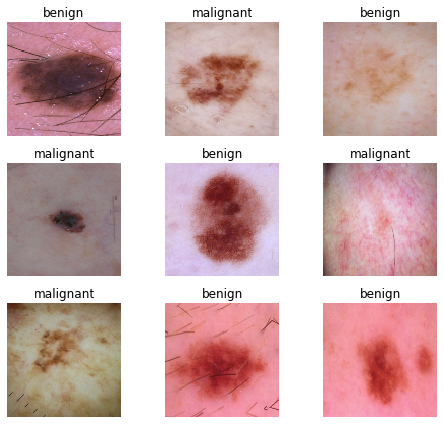

In [53]:
data.show_batch(rows=3,figsize=(7,6))

### Resnet 34 - 2 Stage Iterative Resizing

In [58]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


### Attempt using Resnet 34

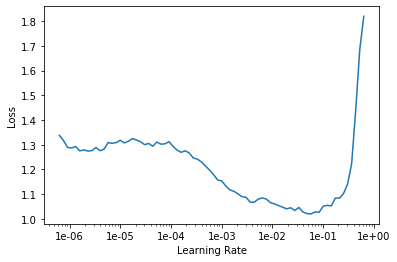

In [60]:
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(7, (1e-01)/8)

epoch,train_loss,valid_loss,error_rate,time
0,0.832654,0.595831,0.192716,00:04
1,0.596963,0.676797,0.303490,00:04
2,0.489856,0.452596,0.172989,00:04
3,0.409629,0.322934,0.133536,00:04
4,0.339789,0.289604,0.132018,00:04
5,0.290533,0.279358,0.133536,00:04
6,0.250104,0.280368,0.130501,00:04


- what matters is getting up real close with the learning rate.
- sze 112 only seems to get to 87 percent accuracy

In [63]:
#learn.save('stage-1-128-rn34-87')

### Model Fine-tuning

In [64]:
#learn.load('stage-1-128-rn34-87')

In [65]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


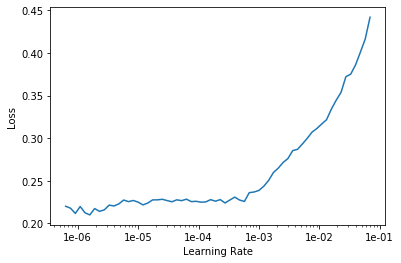

In [66]:
learn.lr_find()
learn.recorder.plot()

In [67]:
learn.fit_one_cycle(6, (1e-3)/8)

epoch,train_loss,valid_loss,error_rate,time
0,0.235166,0.281820,0.132018,00:05
1,0.258672,0.316041,0.135053,00:05
2,0.245796,0.276826,0.133536,00:05
3,0.226189,0.246125,0.110774,00:05
4,0.193284,0.242541,0.115326,00:05
5,0.169345,0.240872,0.113809,00:05


1e-4 best is 0.071

Current best stage 2 error is 0.061457. Really variable

In [69]:
#learn.save('stage-2-128-rn34-89')

### Upsize to 224
Reset data, 224

In [ ]:
learn.load('stage-2-128-rn34-89')

In [70]:
data = ImageDataBunch.from_folder(path, train="/train", valid_pct=0.2,
                                  ds_tfms=tfms, size=224, bs=bs).normalize(imagenet_stats)
learn.data = data

In [71]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


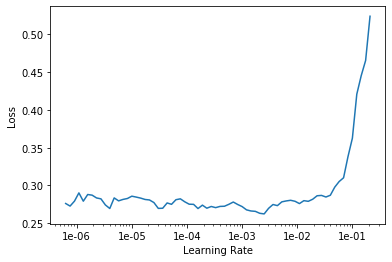

In [72]:
learn.lr_find()
learn.recorder.plot()

In [73]:
lr = 1e-2/2
learn.fit_one_cycle(6, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.253241,0.229541,0.101669,00:10
1,0.242580,0.212097,0.091047,00:10
2,0.223268,0.206654,0.084977,00:10
3,0.215980,0.193154,0.088012,00:10
4,0.210039,0.199937,0.086495,00:10


In [ ]:
#learn.save('stage-1-224-rn34-92')

In [75]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.219488,0.197639,0.084977,00:12
1,0.225962,0.194946,0.075873,00:12
2,0.208599,0.197218,0.086495,00:13
3,0.185665,0.193159,0.086495,00:13


## Resnet-50 Attempt
Just repeating the process using the resnet 50 model. 

In [22]:
torch.cuda.empty_cache()

In [23]:
#learn.destroy()

In [24]:
data50 = data = ImageDataBunch.from_folder(path, train="/train", valid_pct=0.2,
                                  ds_tfms=tfms, size=224, bs=bs//2).normalize(imagenet_stats)

In [25]:
learn50 = cnn_learner(data50, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


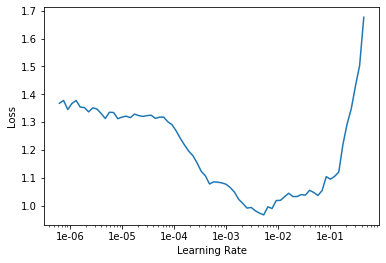

In [26]:
learn50.lr_find()
learn50.recorder.plot()

In [26]:
learn50.fit_one_cycle(7, slice(1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,0.462999,0.311064,0.137329,00:26
1,0.461905,0.339669,0.146434,00:24
2,0.366025,0.312372,0.135053,00:24
3,0.289474,0.258119,0.115326,00:24
4,0.251335,0.216946,0.097117,00:25
5,0.213722,0.192665,0.089530,00:25
6,0.192467,0.185441,0.079666,00:25


In [27]:
# learn50.save('stage-1-50')

In [28]:
# learn50.load('stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (5276 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
malignant,malignant,malignant,malignant,malignant
Path: data;

Valid: LabelList (1318 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
malignant,malignant,malignant,malignant,benign
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [29]:
learn50.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


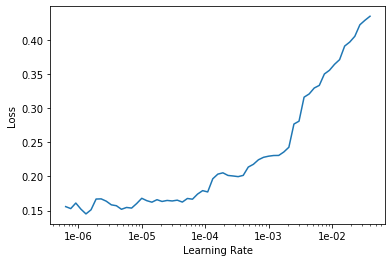

In [30]:
learn50.lr_find()
learn50.recorder.plot()

In [31]:
learn50.fit_one_cycle(5, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.177295,0.200229,0.085736,00:33
1,0.171174,0.214690,0.109256,00:33
2,0.177582,0.162387,0.069044,00:33
3,0.136452,0.163405,0.067527,00:33
4,0.123209,0.155374,0.060698,00:33


In [32]:
# learn50.save('stage-2-50')

In [36]:
learn50.export()

### First results interpretation:
Turns out I can't actually read Cancer screening images, so I'm just going to go for the full training routine, and maybe we'll get someone to look at this later.

In [33]:
interp = ClassificationInterpretation.from_learner(learn50)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

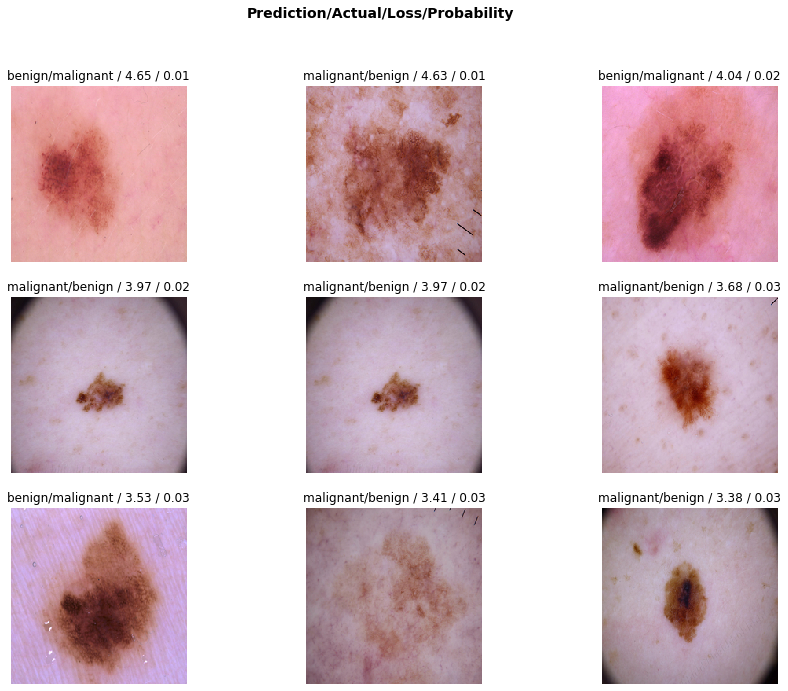

In [34]:
interp.plot_top_losses(9, figsize=(15,11))